# Introduction to numerical robotics

This notebook is a very general introduction to Pinocchio. It presents the main method to manipulate the geometry model of a manipulator robot: set the configuration, compute the position of an effector, check the collision or the distance to the obstacle. The main idea is to give a brief introduction of the general topic: how to discover and learn a robot movement constrained by the environment, using iterative optimization methods.


In [1]:
import magic_donotload

NB: as for all the tutorials, a magic command %do_not_load is introduced to hide the solutions to some questions. Change it for %load if you want to see (and execute) the solution.


## Set up

For this class, we need the UR5 robot model (urdf, in the robotpkg_example_robot_data), the pinocchio python software, the python optimizers from scipy and for the display of the results: the gepetto viewer and the python matplotlib. We have that with this set of imports:

In [2]:
import pinocchio as pin
from utils.meshcat_viewer_wrapper import MeshcatVisualizer
import time
import numpy as np
from numpy.linalg import inv,norm,pinv,svd,eig
from scipy.optimize import fmin_bfgs,fmin_slsqp
from utils.load_ur5_with_obstacles import load_ur5_with_obstacles,Target
import matplotlib.pylab as plt

Let's first load the robot model and display it. You should first start Gepetto Viewer: in a shell (CTRL-ALT-T to open a terminal), run the command: gepetto-gui. A new GUI widow will open (with the logo of our team): this is the viewer. You are not suppose to close this window during the rest of the class, and if you do close it, remember to reopen it before trying to display anything from Python.

For this class, I wrapped the methods to load the robot model and create the obstacle field.

In [3]:
robot = load_ur5_with_obstacles(reduced=True)


The next few lines initialize a 3D viewer.

In [4]:
viz = MeshcatVisualizer(robot)
viz.display(robot.q0)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [5]:
hasattr(viz.viewer, 'jupyter_cell') and viz.viewer.jupyter_cell()

The scene should not be displayed in the viewer (check it). The robot and the red obstacles are encoded in the robot object (we will not need to see in depth what is inside this object). The object Target is the green dot that the robot should reach. You can change the target position by editing target.position, and display the new position with target.display().

You can display a new configuration of the robot with viz.display (take a numpy.array of dimension 6 in input):

In [6]:
viz.display(np.array([3.,-1.5]))

We also set up a target with is visualized as a green dot:

In [7]:
target_pos = np.array([.5,.5])
target = Target(viz,position = target_pos)


## Using the robot model
The robot is originally a 6 degrees-of-freedom (DOF) manipulator. Yet to make the example simple, we will only use the joints 1 and 2. The model has simply be loaded with "frozen" extra joints, which will then not appear in this notebook. Just load the model with reduced=False if you want to recover a model with full DOF.


The following function computes the position of the end effector (in 2d):

In [8]:
def endef(q):
     '''Return the 2d position of the end effector.'''
     pin.framesForwardKinematics(robot.model,robot.data,q)
     return robot.data.oMf[-1].translation[[0,2]]


This function checks if the robot is in collision, and returns True if a collision is detected.

In [9]:
def coll(q):
     '''Return true if in collision, false otherwise.'''
     pin.updateGeometryPlacements(robot.model,robot.data,robot.collision_model,robot.collision_data,q)
     return pin.computeCollisions(robot.collision_model,robot.collision_data,False)


The next function computes the distance between the end effector and the target.

Your code:

In [10]:
def dist(q):
     '''Return the distance between the end effector end the target (2d).'''
     return 0.


Solution

In [11]:
# %load tp0/generated/simple_path_planning_dist
def dist(q):
     '''Return the distance between the end effector end the target (2d).'''
     return norm(endef(q)-target.position)


## Random search of a valid configuration
The free space is difficult to represent explicitely. We can sample the configuration space until a free configuration is found:

In [12]:
def qrand(check=False):
    '''
    Return a random configuration. If check is True, this
    configuration is not is collision
    '''
    pass

The solution if needed:

In [13]:
# %load tp0/generated/simple_path_planning_qrand
def qrand(check=False):
    '''
    Return a random configuration. If check is True, this
    configuration is not is collision
    '''
    while True:
        q = np.random.rand(2)*6.4-3.2  # sample between -3.2 and +3.2.
        if not check or not coll(q): return q


In [14]:
viz.display(qrand(check=True))

Let's now find a valid configuration that is arbitrarily close to the target: sample until dist is small enough and coll is false (you may want to display the random trials inside the loop).

## From a random configuration to the target
Let' s now start from a random configuration. How can we find a path that bring the robot toward the target without touching the obstacles. Any idea?

In [15]:
# Random descent: crawling from one free configuration to the target with random
# steps.
def randomDescent(q0 = None):
     '''
     Make a random walk of 0.1 step toward target
     Return the list of configurations visited
     '''
     q = qrand(check=True) if q0 is None else q0
     hist = [ q.copy() ]
     # DO the walk
     return hist

And solution if needed

In [16]:
# %load tp0/generated/simple_path_planning_random_descent
# Random descent: crawling from one free configuration to the target with random
# steps.
def randomDescent(q0 = None):
     q = qrand(check=True) if q0 is None else q0
     hist = [ q.copy() ]
     for i in range(100):
          dq = qrand()*.1                           # Choose a random step ...
          qtry = q+dq                               # ... apply
          if dist(q)>dist(q+dq) and not coll(q+dq): # If distance decrease without collision ...
               q = q+dq                             # ... keep the step
               hist.append(q.copy())                # ... keep a trace of it
               viz.display(q)                       # ... display it
               time.sleep(5e-3)                     # ... and sleep for a short while
     return hist
randomDescent();


In [17]:
randomDescent()

[array([0.95844127, 1.83847503]),
 array([1.17301124, 1.9662864 ]),
 array([1.09708446, 2.18646021]),
 array([0.95557647, 2.1884098 ]),
 array([0.94824391, 2.30876432]),
 array([1.06425159, 2.61161127]),
 array([1.20969145, 2.86498544]),
 array([1.51660749, 3.04243875]),
 array([1.3785875 , 3.11765451]),
 array([1.19283855, 3.09366592]),
 array([1.03240236, 3.15512519]),
 array([0.98707157, 3.19267068])]

## Configuration space
Let's try to have a better look of the configuration space. In this case, it is easy, as it is dimension 2: we can sample it exhaustively and plot it in 2d. For that, let's introduce another function to compute the distance to collision:

In [18]:
def collisionDistance(q):
     '''Return the minimal distance between robot and environment. '''
     pin.updateGeometryPlacements(robot.model,robot.data,robot.collision_model,robot.collision_data,q)
     if pin.computeCollisions(robot.collision_model,robot.collision_data,False): 0
     idx = pin.computeDistances(robot.collision_model,robot.collision_data)
     return robot.collision_data.distanceResults[idx].min_distance


Now, let's sample the configuration space and plot the distance-to-target and the distance-to-obstacle field (I put 500 samples to spare your CPU, but you need at least 10x more for obtaining a good picture).

In [19]:
def sampleSpace(nbSamples=500):
     '''
     Sample nbSamples configurations and store them in two lists depending
     if the configuration is in free space (hfree) or in collision (hcol), along
     with the distance to the target and the distance to the obstacles.
     '''
     hcol = []
     hfree = []
     for i in range(nbSamples):
          q = qrand(False)
          if not coll(q):
               hfree.append( list(q.flat) + [ dist(q), collisionDistance(q) ])
          else:
               hcol.append(  list(q.flat) + [ dist(q), 1e-2 ])
     return hcol,hfree

def plotConfigurationSpace(hcol,hfree,markerSize=20):
     '''
     Plot 2 "scatter" plots: the first one plot the distance to the target for 
     each configuration, the second plots the distance to the obstacles (axis q1,q2, 
     distance in the color space).
     '''
     htotal = hcol + hfree
     h=np.array(htotal)
     plt.subplot(2,1,1)
     plt.scatter(h[:,0],h[:,1],c=h[:,2],s=markerSize,lw=0)
     plt.title("Distance to the target")
     plt.colorbar()
     plt.subplot(2,1,2)
     plt.scatter(h[:,0],h[:,1],c=h[:,3],s=markerSize,lw=0)
     plt.title("Distance to the obstacles")
     plt.colorbar()

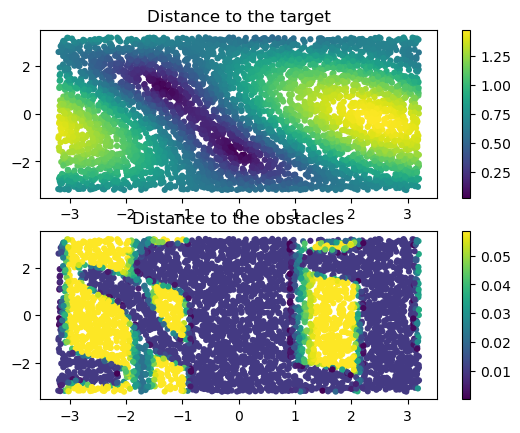

In [20]:
hcol,hfree = sampleSpace(5000)
plotConfigurationSpace(hcol,hfree)


You can try to match your representation of the free space of the robot with this plot. 
As an example, you can display on this plot a feasible trajectory discover by random walk from an init position.

In [21]:
traj = np.array([])
qinit = np.array([-1.1, -3. ])

Here is a solution:

In [22]:
# %load tp0/generated/simple_path_planning_traj
qinit = np.array([-1.1, -3. ])
for i in range(100):
     traj = randomDescent(qinit)
     if dist(traj[-1])<5e-2:
          print('We found a good traj!')
          break
traj = np.array(traj)
### Chose trajectory end to be in [-pi,pi]
qend = (traj[-1]+np.pi) % (2*np.pi) - np.pi
### Take the entire trajectory it modulo 2 pi
traj += (qend-traj[-1])


We found a good traj!


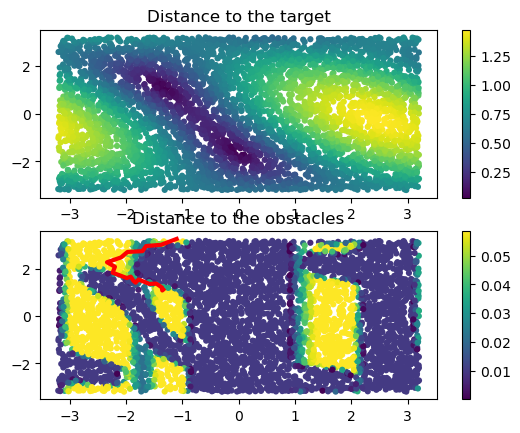

In [23]:
# Add yourr traj to the plot, be carefull !
plotConfigurationSpace(hcol,hfree)
plt.plot(traj[:,0],traj[:,1],'r',lw=3)

## Optimize the distance under non-collision constraint
Finally, let's use one of the classic python solvers (from scipy) to search for a robot configuration that optimizes the distance to the target, under the constraint that the distance to collision is positive.
For that, we need to define a cost function (taking the robot configuration and return a scalar) and a constraint function (taking again the robot configuration and returning a scalar or a vector of scalar that should be positive). We additionally use the "callback" functionnality of the solver, to render the robot configuration corresponding to the current value of the decision variable inside the solver algorithm.
We are going to use the "SLSQP" solver from scipy, which implements a "sequential quadratic program" algorithm and accepts constraints.


In [24]:
def cost(q):
     pass
     
def constraint(q):
     pass
     
def callback(q):
     '''
     At each optimization step, display the robot configuration in gepetto-viewer.
     '''
     viz.display(q)
     time.sleep(.01)

def optimize():
     '''
     Optimize from an initial random configuration to discover a collision-free
     configuration as close as possible to the target.
     USE fmin_slsqp, see doc online
     '''

In [25]:
# %load tp0/generated/simple_path_planning_optim
def cost(q):
     '''
     Cost function: distance to the target
     '''
     return dist(q)**2
     
def constraint(q):
     '''
     Constraint function: distance to the obstacle should be positive.
     '''
     return collisionDistance(q)
     
def callback(q):
     '''
     At each optimization step, display the robot configuration in gepetto-viewer.
     '''
     viz.display(q)
     time.sleep(.1)

def optimize():
     '''
     Optimize from an initial random configuration to discover a collision-free
     configuration as close as possible to the target. 
     '''
     return fmin_slsqp(x0=qrand(check=True),
                       func=cost,
                       f_ieqcons=constraint,
                       callback=callback,
                       full_output=1)
optimize()


Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.2547044722797955e-07
            Iterations: 9
            Function evaluations: 29
            Gradient evaluations: 9


(array([-1.3406664 ,  1.11165713]),
 2.2547044722797955e-07,
 9,
 0,
 'Optimization terminated successfully')

Look at the output of the solver. It always returns a variable value, but sometimes the algorithm fails being traped in an unfeasible region. Most of the time, the solver converges to a local minimum where the final distance to the target is nonzero

Now you can write a planner that try to optimize and retry until a valid solition is found !

In [26]:
# Your solution

And the solution if you need it:

In [27]:
# %load tp0/generated/simple_path_planning_useit
while True:
    res=optimize()
    q=res[0]
    viz.display(q)
    if res[4]=='Optimization terminated successfully' and res[1]<1e-6:
        print('Finally successful!')
        break
    print("Failed ... let's try again! ")


Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.1691602523889414e-09
            Iterations: 8
            Function evaluations: 24
            Gradient evaluations: 8
Finally successful!
